# ResNet-Lie-Detector

---

Javier Fuenzalida

Tomas Herrera

---

Notebook para detectar mentiras utilizando una red neuronal tipo ResNet y entrenada con el set de datos:
Micro Expression Dataset for Lie Detection (https://www.kaggle.com/datasets/devvratmathur/micro-expression-dataset-for-lie-detection)



## Importacion y configuracion de librerias

In [91]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory,load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
import os
from typing import List, Tuple


In [92]:
os.makedirs('models', exist_ok=True)

In [93]:
np.random.seed(65)
tf.random.set_seed(65)

## Importacion de fotos

In [94]:
path = kagglehub.dataset_download("devvratmathur/micro-expression-dataset-for-lie-detection/versions/3")

print("Path to dataset files:", path)

Path to dataset files: /home/jfuenzalida/.cache/kagglehub/datasets/devvratmathur/micro-expression-dataset-for-lie-detection/versions/3


In [95]:
path = '/home/jfuenzalida/.cache/kagglehub/datasets/devvratmathur/micro-expression-dataset-for-lie-detection/versions/3'

train_path = path + "/Train/Train"
test_path = path + "/Test/Test"

print("Path to train files:", train_path)
print("Path to test files:", test_path)

Path to train files: /home/jfuenzalida/.cache/kagglehub/datasets/devvratmathur/micro-expression-dataset-for-lie-detection/versions/3/Train/Train
Path to test files: /home/jfuenzalida/.cache/kagglehub/datasets/devvratmathur/micro-expression-dataset-for-lie-detection/versions/3/Test/Test


## Creacion del dataset

In [96]:
height = 128
width = 128
batch_size = 32

In [97]:
trainSet = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(height, width),
    batch_size=batch_size,
    shuffle=False,
    seed=65
)

Found 12694 files belonging to 2 classes.


In [98]:
testSet = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=(height, width),
    batch_size=batch_size,
    shuffle=False,
    seed=65
)

Found 5838 files belonging to 2 classes.


In [99]:
print(testSet.class_names)
print(trainSet.class_names)

['Lie', 'Truth']
['Lie', 'Truth']


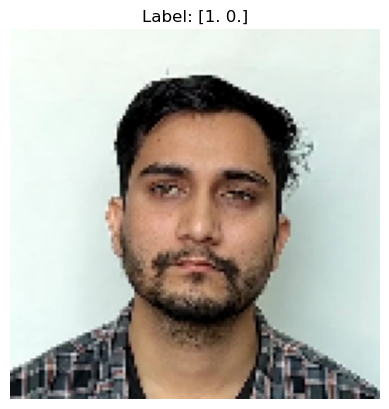

In [100]:
# Obtener el primer batch del dataset
for images, labels in trainSet.take(1):  # take(1) extrae el primer batch
    first_image = images[0].numpy()  # Primera imagen del batch (tensor -> numpy array)
    first_label = labels[0].numpy()  # Etiqueta correspondiente

    # Mostrar la imagen
    plt.imshow(first_image.astype('uint8'))  # Asegurar que los valores estén en [0, 255]
    plt.title(f"Label: {first_label}")
    plt.axis('off')  # Ocultar ejes
    plt.show()

In [101]:
img_data = img_to_array(first_image)
img_data.shape

(128, 128, 3)

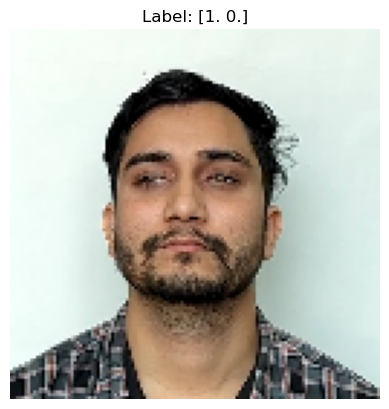

In [102]:
# Obtener el primer batch del dataset
for images, labels in testSet.take(1):  # take(1) extrae el primer batch
    first_image = images[0].numpy()  # Primera imagen del batch (tensor -> numpy array)
    first_label = labels[0].numpy()  # Etiqueta correspondiente

    # Mostrar la imagen
    plt.imshow(first_image.astype('uint8'))  # Asegurar que los valores estén en [0, 255]
    plt.title(f"Label: {first_label}")
    plt.axis('off')  # Ocultar ejes
    plt.show()

In [103]:
img_data = img_to_array(first_image)
img_data.shape

(128, 128, 3)

## Creacion Modelo

Para crear el modelo nos basaremos en el los bloques de identidad y de convolucion descritos en ["ResNet + Keras: code from scratch & train on GPU"](https://www.kaggle.com/code/mishki/resnet-keras-code-from-scratch-train-on-gpu)

### Funciones para creacion de capas ResNet

In [104]:
def bloque_identidad(X: tf.Tensor, level: int, block: int, filters: List[int]) -> tf.Tensor:
    """
    Crea un bloque de identidad 
    """
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X

    # first convolutional layer (plus batch norm & relu layers.Activation, of course)
    X = layers.Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = layers.Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = layers.Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = layers.Activation('relu')(X)

    # third convolutional layer
    X = layers.Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # layers.Add shortcut branch to main path
    X = layers.Add()([X, X_shortcut])

    # relu layers.Activation at the end of the block
    X = layers.Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [105]:
def bloque_convolucional(X: tf.Tensor, level: int, block: int, filters: List[int], s: Tuple[int,int,int]=(2, 2)) -> tf.Tensor:
    """
        Vrea un bloque convolucional
    """

    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X

    # first convolutional layer
    X = layers.Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = layers.Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = layers.Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = layers.Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)

    # third convolutional layer
    X = layers.Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # shortcut path
    X_shortcut = layers.Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = layers.Add()([X, X_shortcut])

    # nonlinearity
    X = layers.Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

### Funcion para crear el modelo ResNet

In [106]:
def ModeloResNet50(input_size: Tuple[int,int,int], classes: int) -> Model:
    # tensor placeholder for the model's input
    X_input = layers.Input(input_size)

    # Capa 1

    # padding
    X = layers.ZeroPadding2D((3, 3))(X_input)

    # convolutional layer, followed by batch normalization and relu activation
    X = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = layers.Activation('relu')(X)

    '''
    Propósito general de esta secuencia inicial
    Procesamiento inicial de la imagen:
    La combinación de ZeroPadding2D + Conv2D(7x7, stride=2) es una forma eficiente de:

    Reducir el tamaño espacial de la imagen (útil para modelos profundos como ResNet).

    Extraer características tempranas de bajo nivel (bordes, colores, patrones simples).

    Preparación para los bloques residuales:
    Esta secuencia es previa a la pila de bloques residuales (el corazón de ResNet). La salida de esta parte ([batch_size, H/2, W/2, 64]) es la entrada para el primer bloque residual.
    
    '''
    # Capa 2

    # max pooling layer to halve the size coming from the previous layer
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = bloque_convolucional(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))

    # 2x identity blocks
    X = bloque_identidad(X, level=2, block=2, filters=[64, 64, 256])
    X = bloque_identidad(X, level=2, block=3, filters=[64, 64, 256])

    # Capa 3

    # 1x convolutional block
    X = bloque_convolucional(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # 3x identity blocks
    X = bloque_identidad(X, level=3, block=2, filters=[128, 128, 512])
    X = bloque_identidad(X, level=3, block=3, filters=[128, 128, 512])
    X = bloque_identidad(X, level=3, block=4, filters=[128, 128, 512])

    # Capa 4

    #1x convolutional block
    X = bloque_convolucional(X, level=4, block=1, filters=[256, 256, 1024], s=(2, 2))
    # 5x identity blocks
    X = bloque_identidad(X, level=4, block=2, filters=[256, 256, 1024])
    X = bloque_identidad(X, level=4, block=3, filters=[256, 256, 1024])
    X = bloque_identidad(X, level=4, block=4, filters=[256, 256, 1024])
    X = bloque_identidad(X, level=4, block=5, filters=[256, 256, 1024])
    X = bloque_identidad(X, level=4, block=6, filters=[256, 256, 1024])

    # Capa 5

    # 1x convolutional block
    X = bloque_convolucional(X, level=5, block=1, filters=[512, 512, 2048], s=(2, 2))
    # 2x identity blocks
    X = bloque_identidad(X, level=5, block=2, filters=[512, 512, 2048])
    X = bloque_identidad(X, level=5, block=3, filters=[512, 512, 2048])

    # Pooling layers
    X = layers.AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax', name='fc_' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ModeloResNet50')

    return model

In [107]:
model = ModeloResNet50(input_size = (height, width, 3), classes = 2)

In [108]:
model.summary()

Model: "ModeloResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1_1_1_conv (Conv2D)        (None, 64, 64, 64)   9472        ['zero_padding2d_2[0][0]']       
                                                                                     

## Ejecuccion del modelo con EarlyStopping

### Creacion del EarlyStopping

In [114]:
early_stopping = EarlyStopping(
    monitor='val_loss',          # Métrica a monitorizar
    patience=3,                  # Detener tras 3 épocas sin mejora
    min_delta=0.01,              # Umbral de mejora mínima (1% en val_loss)
    mode='min',                  # Buscar mínima pérdida (importante para val_loss)
    restore_best_weights=True,   # Recuperar automáticamente los mejores pesos
    verbose=1                    # Mostrar notificaciones
)

checkpoint = ModelCheckpoint(
    filepath='mejor_modelo.keras',  # Ruta donde se guardará el modelo
    monitor='val_loss',          # Métrica a monitorizar (debe coincidir con early_stopping)
    save_best_only=True,         # Solo guarda el modelo con mejor val_loss
    mode='min',                  # Minimizar val_loss
    verbose=1                    # Muestra mensajes al guardar
)

### Entrenamiento

In [115]:
model.fit(
    trainSet,
    validation_data=testSet,      # Asegúrate de pasar validation_data
    epochs=50,                  # Máximo de épocas (el early stopping puede cortar antes)
    callbacks=[early_stopping, checkpoint]    # Añadir el callback
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.